# End-to-end 1D Simulation for Geophysical Inversion with UXO Detection

In [28]:
import numpy as np

class UXO_object:
    def __init__(self,
                 center: np.ndarray,
                 major_axis: float,
                 minor_axis: float,
                 strike: float,
                 dip: float):
        self.center = center
        self.major_axis = major_axis
        self.minor_axis = minor_axis
        self.strike = strike
        self.dip = dip

    def _compute_rotation_matrix(self, inverse: bool = False):
        # y-axis rotation
        theta = self.dip * np.pi / 180
        Ay = np.r_[
            np.c_[np.cos(theta), 0.0, -np.sin(theta)],
            np.c_[0.0, 1.0, 0.0],
            np.c_[np.sin(theta), 0.0, np.cos(theta)],
        ]

        # z-axis rotation
        phi = self.strike * np.pi / 180
        Az = np.r_[
            np.c_[np.cos(phi), -np.sin(phi), 0.0],
            np.c_[np.sin(phi), np.cos(phi), 0.0],
            np.c_[0.0, 0.0, 1.0],
        ]

        return np.dot(Ay, Az) if not inverse else np.dot(Az.T, Ay.T)

    def define_pts(self, n_points: int = 10):
        raise NotImplementedError
    
    def get_vertical_intersects(self, x: float, y: float):
        rot = self._compute_rotation_matrix()
        rot_inv = self._compute_rotation_matrix(inverse=True)
        pt0 = np.array([x, y, 0]) - self.center
        pt = np.dot(pt0, rot_inv)
        vec = np.dot(np.array([0, 0, 1]), rot_inv)

        # find quadratic coefficients
        a = (vec[0]**2 + vec[1]**2)/self.minor_axis**2 + vec[2]**2/self.major_axis**2
        b = 2*((pt[0]*vec[0]+pt[1]*vec[1])/self.minor_axis**2 + pt[2]*vec[2]/self.major_axis**2)
        c = (pt[0]**2 + pt[1]**2)/self.minor_axis**2 + pt[2]**2/self.major_axis**2 - 1

        # find intersection points
        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            return None
        else:
            t1 = (-b + np.sqrt(discriminant))/(2*a)
            t2 = (-b - np.sqrt(discriminant))/(2*a)
            p1 = np.dot(np.array([pt + t1*vec]), rot) + self.center
            p2 = np.dot(np.array([pt + t2*vec]), rot) + self.center
            return p1[0,2], p2[0,2]

In [47]:
uxo = UXO_object(np.array([0, 0, -10]), 4, 1, 135, 45)
uxo.get_vertical_intersects(0, 0)

(-8.62801131885993, -11.371988681140069)

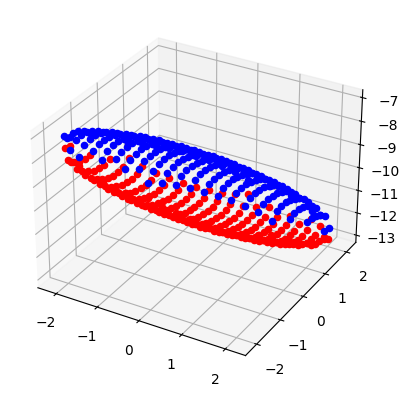

In [48]:
x_vals = np.linspace(-5, 5, 50)
y_vals = np.linspace(-5, 5, 50)

# plot the surface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for x in x_vals:
    for y in y_vals:
        z = uxo.get_vertical_intersects(x, y)
        if z is not None:
            ax.scatter(x, y, z[0], c='b')
            ax.scatter(x, y, z[1], c='r')
plt.show()